# Traffic Forecasting with Pytorch Geometric Temporal


## Installation

In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

2.0.1+cu117


This took some time for me, so be patient :)

VERY IMPORTANT: all the dependencies need python 3.9!!

For pytorch with cuda, wheel can be found here: https://download.pytorch.org/whl/torch/

In [ ]:
!pip install pandas==1.3.5

In [8]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

if previous line worked, then the next one should not be necessary

In [6]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
                                              0.0/499.9 kB ? eta -:--:--
                                              10.2/499.9 kB ? eta -:--:--
                                              10.2/499.9 kB ? eta -:--:--
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ------                                81.9/499.9 kB 255.1 kB/s eta 0:00:02
     -------                              102.4/499.9 kB 281.0 kB/s eta 0:00:02
     -------                              102.4/499.9 kB 281.0 kB/s eta 0:00:02
     --------                             112.6/499.9 kB 242.7 kB/s eta 0:00:02
     ---------------                      215.0/499.9 kB 452.1 kB/s eta 0:00:01
     ---------------                      215.0/499.9 kB 452.1 kB/s eta 0:0

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [2]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


In [4]:
train_2022 = np.load("data_bicimad/preprocessed/train_GNN_2022_std.npy")


In [5]:
import os
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from six.moves import urllib

class BICIMADloader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir, raw_data_name, adj_mat_name):
        self.raw_data_dir = raw_data_dir
        self.raw_data_name = raw_data_name
        self.adj_mat_name = adj_mat_name
        self._load_data()

    
    def _load_data(self):
        #loads data, already preprocessed and normalized!
        A = np.load(os.path.join(self.raw_data_dir, self.adj_mat_name))
        X = np.load(os.path.join(self.raw_data_dir, self.raw_data_name)).transpose(
            (1, 2, 0)
        ).astype(np.float32)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)
        

    def _get_edges_and_weights(self):
        #gets adjacency matrix and transforms it to correct format
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self,target_variable,slide = 1, num_timesteps_in: int = 24, num_timesteps_out: int = 24):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i*slide, i*slide + (num_timesteps_in + num_timesteps_out))
            for i in range(int((self.X.shape[2] - (num_timesteps_in + num_timesteps_out))/slide))
        ]

        # Generate observations
        features, target = [], []
        if target_variable == "plugs":
            target_index = 0
        if target_variable == "unplugs":
            target_index = 1
        for i, j in indices:
            #it assumes that first column will always be the target
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, target_index, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, target_variable, slide = 1,num_timesteps_in: int = 24, num_timesteps_out: int = 24
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(target_variable,slide,num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset


In [9]:

loader = BICIMADloader(raw_data_dir=os.path.join("data_bicimad","GNN_data"), raw_data_name="train_GNN_2022_std.npy",adj_mat_name="adj_mat.npy")
train_dataset = loader.get_dataset(target_variable = "plugs",slide=168,num_timesteps_in=168, num_timesteps_out=168)

## Checking target coherence

We need to make sure that at all points the target is the one we want it to be, so we are going to check that we obtain the same results for the first week of predictions (2nd week of the dataset). The first week in the targets will be the second week in the training data, as we use the plugs or unplugs of the current week to predict next plugs or unplugs. We assume that the predictions will be done on thursday of the first week using all the information of the first week to predict values on the second week.

We need to make sure that the processing of the data does not break anything

<Axes: >

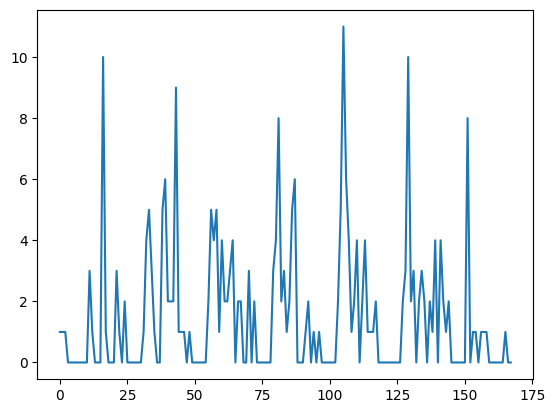

In [10]:
# checking 2nd week from data (this will be first bunch of targets)
import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = [hour for hour in train_2022[168:2*hours,0,0]]
sns.lineplot(data=sensor_labels)

<Axes: >

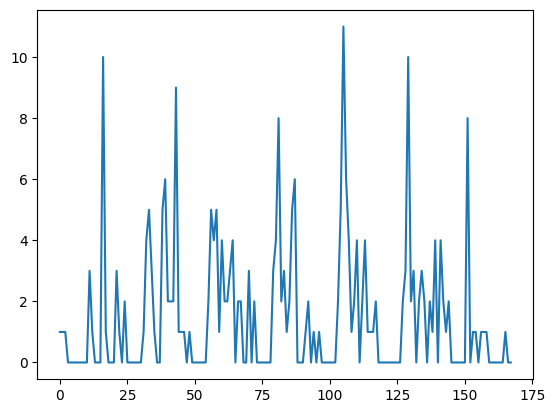

In [11]:
# checking 2nd week from X after processing (this will be first bunch of targets)
import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = [int(hour.detach().cpu().numpy()) for hour in loader.X[0,0,hours:2*hours]]
sns.lineplot(data=sensor_labels)

<Axes: >

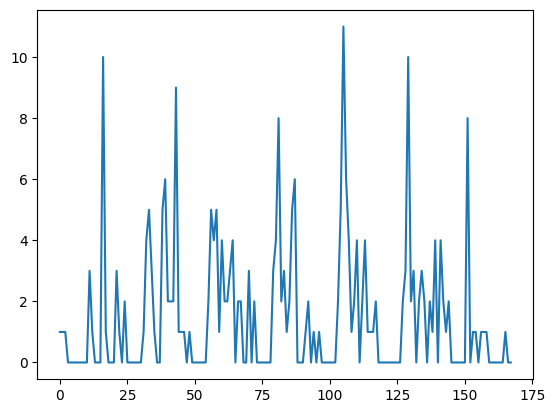

In [12]:
# checking 2nd week from target in loader object (this will be first bunch of targets)
import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = [hour for hour in loader.targets[0][0,0:hours]]
sns.lineplot(data=sensor_labels)

<Axes: >

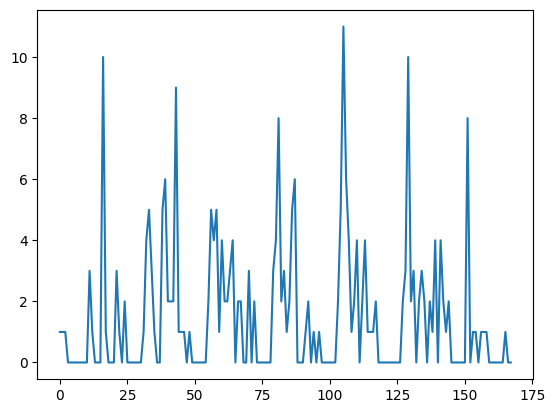

In [13]:
# checking 2nd week from target in dataset object (this will be first bunch of targets)
import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = [hour for hour in train_dataset.targets[0][0,0:hours]]
sns.lineplot(data=sensor_labels)


everything matches, data structure seems coherent.

#### Data Sample
- 170 nodes
- 28 features per node (speed, time)
- 168 timesteps per bucket (7*24h = 168 = 1 week)
- Labels for 168 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between stations


In [14]:
# Show first sample
next(iter(train_dataset))

Data(x=[170, 32, 168], edge_index=[2, 28706], edge_attr=[28706], y=[170, 168])

## Model

Which model to choose depends on which time-series task you work on.

- A3TGCN is an extension of TGCN that uses attention
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=26, periods=168)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(26, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(26, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(26, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=168, bias=True)
)

## Training

- Training on GPU didn't bring much speed-up
- I ran into RAM issues, why I only train on a smaller subset of the data

In [18]:
!nvidia-smi

Fri Jun 30 01:14:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P5              27W / 170W |   1122MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [63]:
import argparse
import shutil
import os
import time
import random
from enum import Enum
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts

from torch.utils.tensorboard import SummaryWriter

import logging
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

def save_checkpoint(state, is_best, args,filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join('best_models',args.experiment_name+'_model_best.pth'))

class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

In [64]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        logging.info('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        logging.info(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [65]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def all_reduce(self):
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        total = torch.tensor([self.sum, self.count], dtype=torch.float32, device=device)
        # dist.all_reduce(total, dist.ReduceOp.SUM, async_op=False)
        self.sum, self.count = total.tolist()
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)

In [66]:
def train(train_dataset, model, criterion, optimizer, epoch, device, writer, args):
    batch_time = AverageMeter('Time', ':6.3f')
    # data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')

    progress = ProgressMeter(
        train_dataset.snapshot_count,
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()

    for i,snapshot in enumerate(train_dataset):
        
        snapshot = snapshot.to(device)
        optimizer.zero_grad()
        
        # compute prediction
        y_hat = model(snapshot.x, snapshot.edge_index)
        
        loss = criterion(y_hat, snapshot.y)
        losses.update(loss.item())
        
        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/train", losses.avg, epoch)
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i + 1)
    return writer

In [67]:
def validate(val_dataset, model, criterion,device, writer, epoch, args):

    def run_validate(val_dataset, base_progress=0):
        with torch.no_grad():
            end = time.time()
            
            for i,snapshot in enumerate(val_dataset):
                i = base_progress + i
                snapshot = snapshot.to(device)
                # compute output
                y_hat = model(snapshot.x, snapshot.edge_index)
                loss = criterion(y_hat, snapshot.y)

                # measure accuracy and record loss
                losses.update(loss.item())

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if i % args.print_freq == 0:
                    progress.display(i + 1)

    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.NONE)
    progress = ProgressMeter(
        val_dataset.snapshot_count,
        [batch_time, losses],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    run_validate(val_dataset)

    progress.display_summary()
    
    writer.add_scalar("Loss_student/Val", losses.avg, epoch)

    return losses.avg, writer

In [68]:
#args
class argclass(object):
    def __init__(self, *initial_data,**kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])


hyperparams1={"root":os.path.join("data_bicimad","GNN_data"),
              "training_file":"train_GNN_2022_std.npy",
              "validation_file":"test_GNN_2022_std.npy",
              "target_variable":"plugs",
              'lr':0.03,
              "LR_step_size":1, 
              "LR_step_gamma":0.5,
             'momentum':0.9,
             'weight_decay':1e-4,
             'epochs':3,
             'start_epoch':0,
             'print_freq':1,
             'model':TemporalGNN(node_features=32, periods=168),
             "experiment_name":"test_architecture",
            }


args=argclass(hyperparams1)

In [69]:
# main

best_val_loss = 0


#load datasets
loader = BICIMADloader(raw_data_dir=args.root, raw_data_name=args.training_file,adj_mat_name="adj_mat.npy")
train_dataset = loader.get_dataset(target_variable=args.target_variable,slide=168,num_timesteps_in=2*168, num_timesteps_out=168)


loader = BICIMADloader(raw_data_dir=args.root, raw_data_name=args.validation_file,adj_mat_name="adj_mat.npy")
val_dataset = loader.get_dataset(target_variable=args.target_variable,slide=168,num_timesteps_in=2*168, num_timesteps_out=168)

writer = SummaryWriter(log_dir=os.path.join("tensorboard", args.experiment_name))

#calling device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
        logging.info("Use GPU for training : CUDA version {}, device:{}".format(torch.version.cuda,device))

if not torch.cuda.is_available():
        logging.info('using CPU, this will be slow')

# create model
model = args.model.to(device)

logging.info("=> Loading Teacher model '{}'".format(model._get_name()))

model = model.to(device)

# define loss function (criterion), optimizer, and learning rate scheduler

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss(reduction="mean")
        loss = torch.sqrt(criterion(x, y))
        return loss

criterion = RMSELoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                        weight_decay=args.weight_decay)

"""Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
scheduler = StepLR(optimizer, step_size=args.LR_step_size, gamma=args.LR_step_gamma)#0.1)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = args.epochs + 1, T_mult=1, eta_min=args.min_lr, verbose=False)

for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        writer = train(train_dataset, model, criterion, optimizer, epoch, device, writer, args)

        # evaluate on validation set # change this as this is the measure of whether the model is good or not versus the training/ validation set
        val_loss, writer = validate(val_dataset, model, criterion,device, writer, epoch, args)
        
        scheduler.step()
        
        # remember best acc@1 and save checkpoint
        is_best = val_loss < best_val_loss
        best_val_loss = min(val_loss, best_val_loss)


        save_checkpoint(
                state={'epoch': epoch + 1,
                'model': args.model,
                'best_val_loss': best_val_loss,
                'optimizer' : optimizer.state_dict(),
                'scheduler' : scheduler.state_dict()
                }, 
                is_best=is_best,
                args=args,
                filename=os.path.join("checkpoints",args.experiment_name +'_checkpoint.pth.tar'))
writer.flush()

INFO:root:Use GPU for training : CUDA version 11.7, device:cuda:0
INFO:root:=> Loading Teacher model 'TemporalGNN'
INFO:root:Epoch: [0][  1/153]	Time  1.168 ( 1.168)	Loss 3.8952e+00 (3.8952e+00)
INFO:root:Epoch: [0][  2/153]	Time  1.076 ( 1.122)	Loss 3.7579e+00 (3.8265e+00)
INFO:root:Epoch: [0][  3/153]	Time  1.235 ( 1.160)	Loss 3.7340e+00 (3.7957e+00)
INFO:root:Epoch: [0][  4/153]	Time  1.153 ( 1.158)	Loss 3.6627e+00 (3.7624e+00)
INFO:root:Epoch: [0][  5/153]	Time  1.119 ( 1.150)	Loss 3.5387e+00 (3.7177e+00)
INFO:root:Epoch: [0][  6/153]	Time  0.923 ( 1.112)	Loss 3.4784e+00 (3.6778e+00)
INFO:root:Epoch: [0][  7/153]	Time  0.920 ( 1.085)	Loss 3.1140e+00 (3.5973e+00)
INFO:root:Epoch: [0][  8/153]	Time  0.907 ( 1.063)	Loss 3.3101e+00 (3.5614e+00)
INFO:root:Epoch: [0][  9/153]	Time  0.948 ( 1.050)	Loss 3.0598e+00 (3.5056e+00)
INFO:root:Epoch: [0][ 10/153]	Time  0.927 ( 1.038)	Loss 3.1370e+00 (3.4688e+00)
INFO:root:Epoch: [0][ 11/153]	Time  0.887 ( 1.024)	Loss 2.9231e+00 (3.4192e+00)
INFO:

In [19]:
# GPU support
from torch import nn

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
    

device = torch.device('cuda') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=32, periods=168).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = RMSELoss().to(device)
model.train()

print("Running training...")
for epoch in range(3):
    print(epoch)

    j = 0
    for snapshot in train_dataset:
        j+=1
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        # we apply stochastic gradient descent(batch = 1)
        RMSE_loss = criterion(y_hat, snapshot.y)
        RMSE_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        print("week: {}/{}, traaain MSE: {:.4f}".format(j,train_dataset.snapshot_count, RMSE_loss.item()))

    
    
    print("Epoch {} train MSE: {:.4f}".format(epoch, RMSE_loss.item()))

Running training...
0
week: 1/154, traaain MSE: 3.6280
week: 2/154, traaain MSE: 3.8995
week: 3/154, traaain MSE: 3.8596
week: 4/154, traaain MSE: 4.0365
week: 5/154, traaain MSE: 4.1818
week: 6/154, traaain MSE: 4.2779
week: 7/154, traaain MSE: 4.4361
week: 8/154, traaain MSE: 4.1645
week: 9/154, traaain MSE: 4.6139
week: 10/154, traaain MSE: 4.4374
week: 11/154, traaain MSE: 4.6256
week: 12/154, traaain MSE: 4.0499
week: 13/154, traaain MSE: 4.1797
week: 14/154, traaain MSE: 3.0370
week: 15/154, traaain MSE: 3.7783
week: 16/154, traaain MSE: 4.0885
week: 17/154, traaain MSE: 4.8590
week: 18/154, traaain MSE: 4.8727
week: 19/154, traaain MSE: 5.1048
week: 20/154, traaain MSE: 6.2431
week: 21/154, traaain MSE: 6.4911
week: 22/154, traaain MSE: 7.5706
week: 23/154, traaain MSE: 6.1434
week: 24/154, traaain MSE: 5.3359
week: 25/154, traaain MSE: 4.5270
week: 26/154, traaain MSE: 3.5738
week: 27/154, traaain MSE: 0.1630
week: 28/154, traaain MSE: 0.1413
week: 29/154, traaain MSE: 2.3997
w

In [196]:
loader.X.shape

torch.Size([170, 26, 8470])

## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [22]:
model.eval()
loss = 0
step = 0
horizon = 10

loader = BICIMADloader(raw_data_dir=os.path.join("data_bicimad","GNN_data"), raw_data_name="test_GNN_2022_std.npy",adj_mat_name="adj_mat.npy")
test_dataset = loader.get_dataset(target_variable="plugs",slide=168,num_timesteps_in=168, num_timesteps_out=168)
# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 3.2995


In [131]:
predictions[0].shape

torch.Size([170, 168])

### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [156]:
preds.shape

(1848,)

### Average over all stations

In [23]:
import numpy as np

sensor = 3
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred.detach().cpu().numpy() for pred in predictions])
preds=preds.reshape((170,168*(horizon+1)))
preds = np.sum(preds, axis=0)

labs = np.asarray([lab.detach().cpu().numpy() for lab in labels])
labs=labs.reshape((170,168*(horizon+1)))
labs = np.sum(labs, axis=0)


<Axes: >

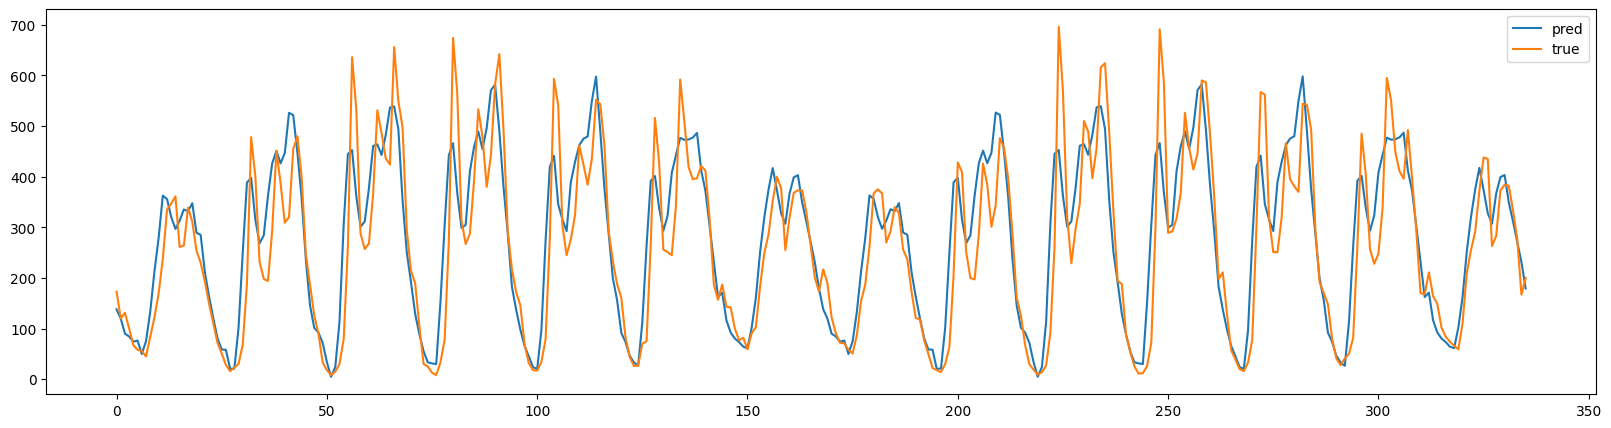

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*4:6*168], label="pred")
sns.lineplot(data=labs[168*4:6*168], label="true")

<Axes: >

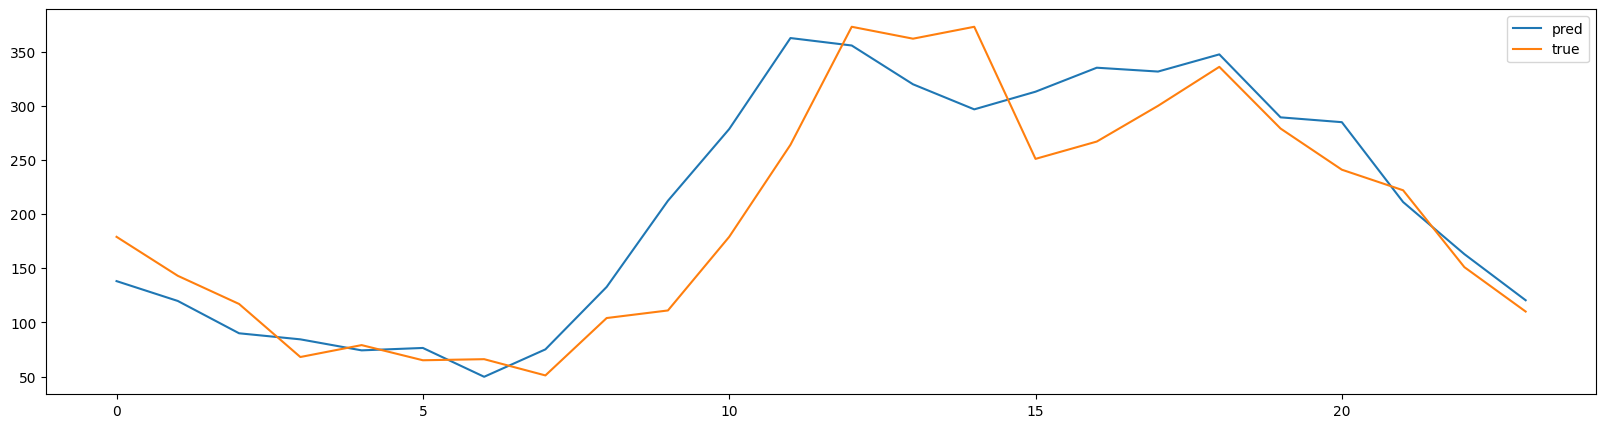

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[:24], label="pred")
sns.lineplot(data=labs[:24], label="true")

### For a single station

In [35]:
predictions[0][station].shape

torch.Size([168])

In [38]:
import numpy as np

station = 3

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon+1))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon+1))


<Axes: >

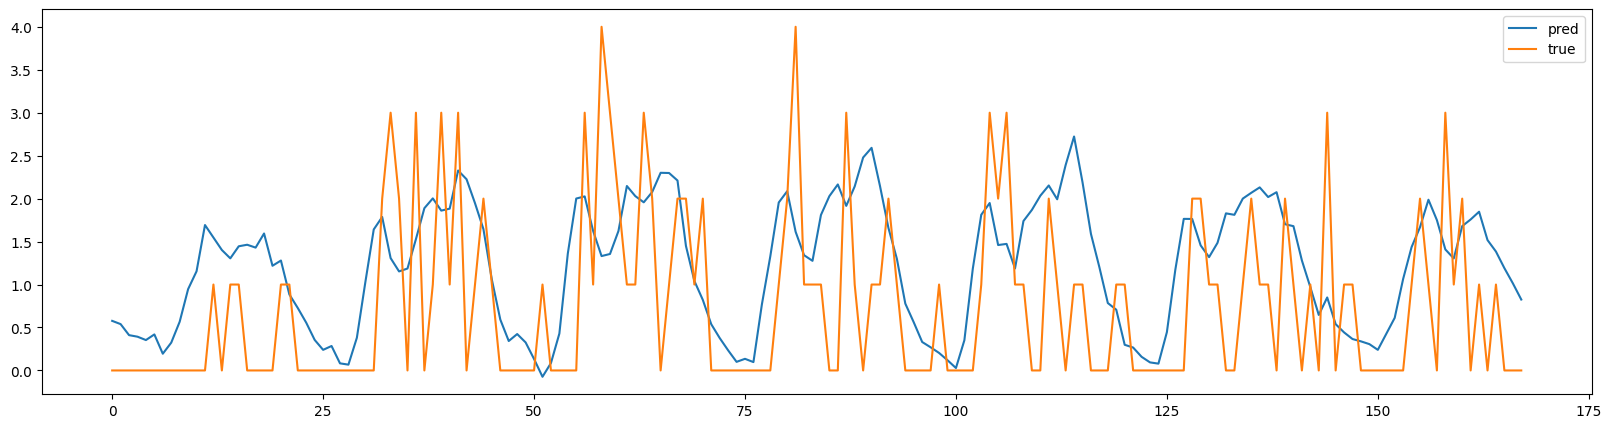

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

In [42]:
import numpy as np

station = 25

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon+1))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon+1))


<Axes: >

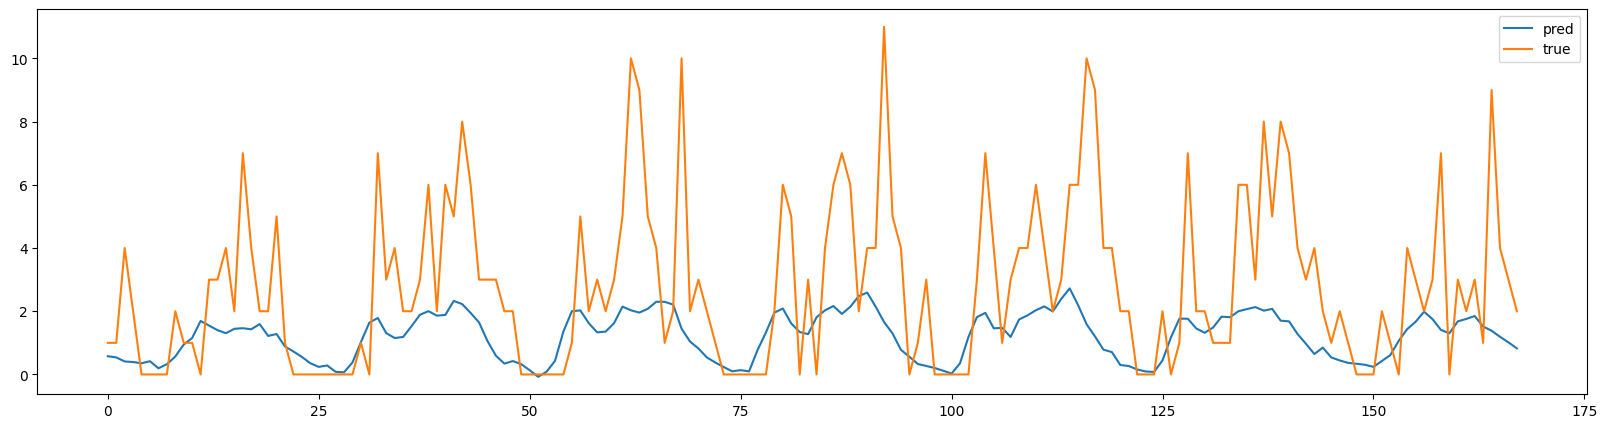

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

In [44]:
import numpy as np

station = 100

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon+1))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon+1))


<Axes: >

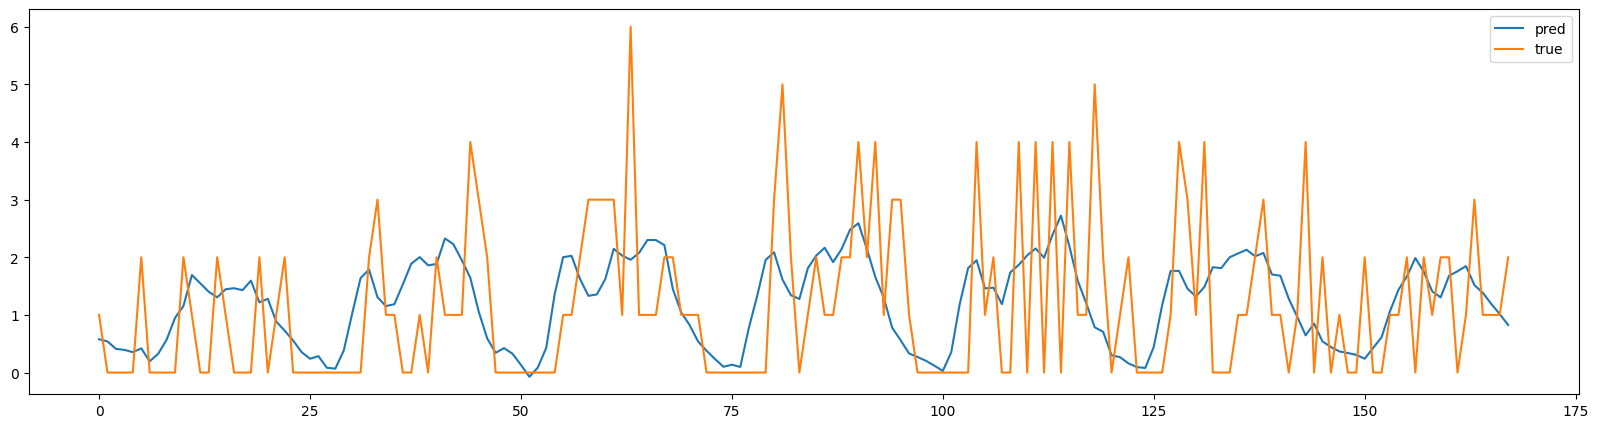

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

# EXPLAINABILITY OF THE GNN!!!!

https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html?highlight=plot